# Image Regression

This notebook will walk you through how to do image regression using the BIWI Head Pose dataset

First, install the libraries and restart your runtime

In [0]:
!pip install torch torchvision feather-format kornia pyarrow Pillow wandb --upgrade 
!pip install git+https://github.com/fastai/fastai_dev    

The goal of this task is to find the center of a head in an image. First, let's grab the libraries we need. We'll use `basics`, `callback` (for `fit_one_cycle`), and `vision`

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

# Grabbing and Preparing our data

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)

Since the data comes from an outside source, they have a particular calibration that needs to be applied to all the data for the coordinate points to work out properly

In [3]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

From here, we can grab a filename to test our calibration and make sure it works. The corresponding text document with the coordinates for each image is saved as the image filename plus 'pose.txt' at the end, so let's make a function to grab a corresponding label

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

In [0]:
fname = '09/frame_00667_rgb.jpg'

For right now, instead of `open_image` we have to use `PILImage.create()` to open an image

In [0]:
img = PILImage.create(path/fname)

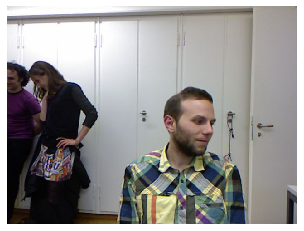

In [7]:
img.show()

Now let's grab the center coordinate for our image

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

This is not useable to us yet, they are their own "BIWI" coordinates. THankfully, they described how we can convert this into an `x` and `y` for us to use with their earlier calibration. We also want it to return a `tensor` for our model to use

In [0]:
def convert_biwi(coords:array):
  x = coords[0] * cal[0][0]/coords[2] + cal[0][2]
  y = coords[1] * cal[1][1]/coords[2] + cal[1][2]
  return tensor([x,y])

We'll also create a helper function that will call `np.genfromtxt` to clean up our program

In [0]:
def get_ctr(f:Path):
  ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
  return convert_biwi(ctr)

Lastly we will create a getter to grab our actual `ImagePoints` that our model is expecting. For fastai v2, instead of `ImagePoints` we have `TensorPoint`, which we pass in the points as well as how big of an image size to expect

In [0]:
def get_ip(img:PILImage, pts:array): return TensorPoint.create(pts, sz=img.size)

Let's try them out!

In [12]:
get_ctr(fname)

tensor([428.5814, 263.9104])

Now, if we try plotting this to our earlier image, all should work well. For us to plot our points, we need to call a `.show()` to our `TensorPoint` object and define the axes we want to show it on (`ctx`)

In [13]:
ctr = get_ctr(fname); ctr

tensor([428.5814, 263.9104])

In [14]:
ip = get_ip(img, ctr); ip

tensor([[428.5814, 263.9104]])

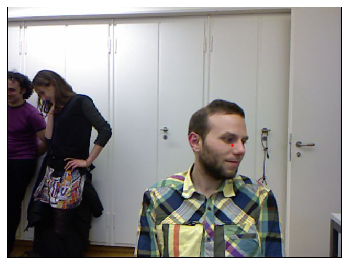

In [15]:
ax = img.show(figsize=(6,6))
ip.show(ctx=ax)

It will look a bit off, that's how the data came, don't let that stress you. Now let's see how to pull this all into the `DataBlock` API. The old version looked like below:

In [0]:
### DO NOT RUN! JUST FOR SHOW OF HOW THE 1.0 API LOOKED ###
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

Our `DataBlock` object will need to know a few things. Our `blocks` will be an `ImageBlock` for our input, and a `PointBlock` for our outputs. Our `get_items` will just be `get_image_files` again, and our splitter will need to be a `FuncSplitter`. Lastly, our `get_y` function will be our `get_ctr` we made above

In [0]:
splitter = FuncSplitter(lambda o: o.parent.name=='13')

The splitter is exactly like our old one, where we will split by the '13' folder

In [0]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   splitter=splitter,
                   get_y=get_ctr)

Now we can create our `DataBunch` object. 

For our `DataBunch` creation, our `source` and our `path` both point to the same thing

In [0]:
dbunch = dblock.databunch(path, path=path, bs=64, batch_tfms=[*aug_transforms(size=(120,160)), Normalize(*imagenet_stats)])

Let's take a look to make sure our data came out okay!

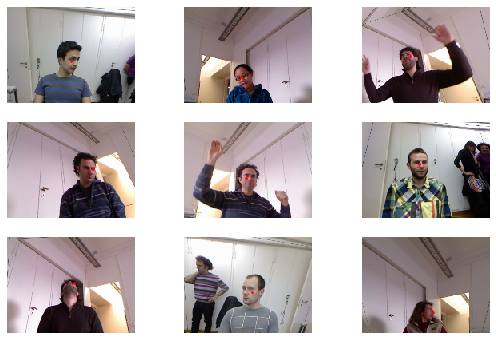

In [19]:
dbunch.show_batch(max_n=9, figsize=(9,6))

It looks a bit off but it's right!

# Training

Now let's train a model. We'll use a resnet34. For right now we need to assign `dbunch.c` to the `after_item` in our databunch. Eventually this will be done automatically

In [0]:
dbunch.c = dbunch.train_dl.after_item.c

Now we can create our model!

In [0]:
learn = cnn_learner(dbunch, resnet34)

And find a good learning rate

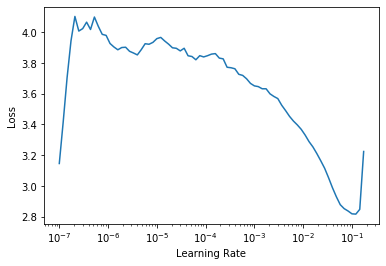

In [24]:
learn.lr_find()

Let's pick somewhere around 3e-2 for our learning rate

In [25]:
learn.fit_one_cycle(5, slice(3e-2))

epoch,train_loss,valid_loss,time
0,0.136341,0.010308,02:12
1,0.024188,0.012561,02:10
2,0.012147,0.003483,02:09
3,0.008537,0.003643,02:10
4,0.006806,0.002881,02:09


And now we can view our results to check our model and we're done!

epoch,train_loss,valid_loss,time
0,0.136341,0.010308,02:12
1,0.024188,0.012561,02:10
2,0.012147,0.003483,02:09
3,0.008537,0.003643,02:10
4,0.006806,0.002881,02:09


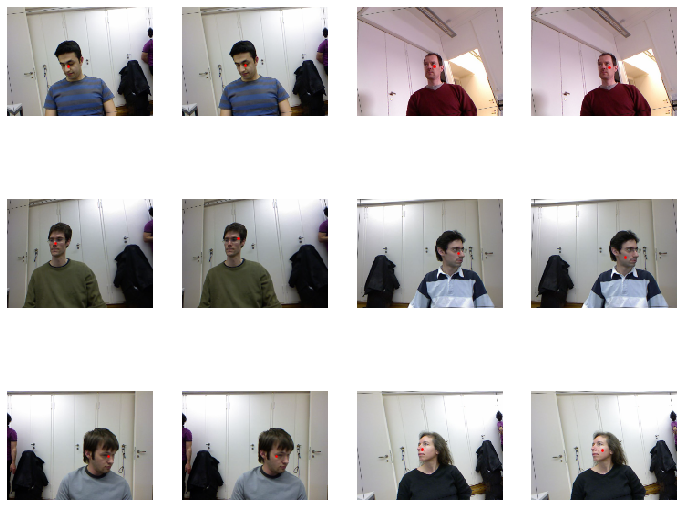

In [27]:
learn.show_results(max_n=6)